In [1]:
from pecebl.designer import designer as pg
from pecebl.psf_import.casino import Casino3 as cs3
from pecebl.ebl_kernels import kernels as ker
from pecebl.sem import supra40 as beamer
from pecebl.utils import *

import imageio

## 0) Use Casino3 software

In this first demo I use a PSF from Casino3 to expose a demo pattern.

The Casino3 software can be downloaded here http://www.gel.usherbrooke.ca/casino/. You have to register to download

The demo sample is a 300nm ZEP520A resist layer on a silicon substrate. For this example I use 1e7 electrons with 30kV of accelerate voltage and the options are:

    no generate secondary electrons,
    1nm beam diameter,
    100 mrad beam semi-angle
    1.65 gaussian beam distribution.
    cartesian distribution for data
    ...

more parameters are in the sample file _ZEP520A300_Si.sim_ given with this demo.

The PSF is saved in _zep520_1e7_30kV_100mrad_1pt_ file. This file will be used in this example.

## 1) Create an example pattern : photonic crystal
The example for this demo

In [2]:
# create phC sites:
#parameter of the phC:
r=48.0 #radius (nm) of the hole
a=170.0 #pitch (nm) between 2 holes
ss=4 #stepsize (nm)

start = timer()
final_pattern=pg.example1(a,r,ss)
dt = timer() - start
print("total {} points created in {} s".format(final_pattern.shape[0], dt))
playsound(freq,duration)

total 275781 points created in 1.5710457499999997 s


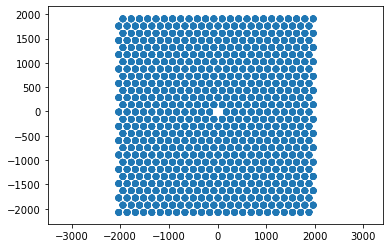

In [3]:
#plot the phC:
plt.plot(final_pattern[:,0], final_pattern[:,1], 'o', ms=1)
plt.axis('equal');plt.show()

## 2) Hardware setup and import simulated data from Casino3
SEM : voltage and aperture

Beam writer : speed (Hz)

Monte-Carlo data: import psf file _zep520_1e7_30kV_100mrad_1pt_ from Casino3

In [4]:
meb = beamer.Supra40(30) #we use a sem Zeiss Supra40 at 30kV
meb.change_aperture(7.5) #use the 7.5 µm aperture
meb.info()

SEM info:
current aperture size: 7.5 µm
current voltage: 30 kV
beam current: 28 pA



In [5]:
casino_file='data/zep520_1e7_30kV_100mrad_1pt' #data from Casino3 software
sim=cs3(casino_file)

In [6]:
# the data is simulated with 1e7 electrons
# the ElphyPlus has 6 MHz of speed
# iy, i_y  = 3, 3 : we are at the peak of the psf and at the mid-depth of the ebeam resist
# according to the simulation parameters
# we prepare the psf:
pre_psf=get_pre_psf(1e7, sim, 6, meb.beam_current, i_y=3, i_z=3)

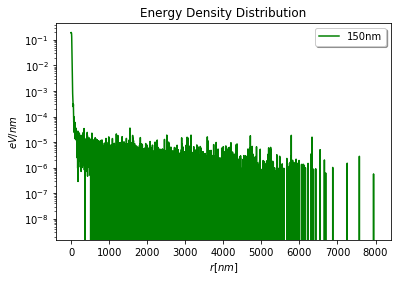

min value = 0.0; mean value = 0.0004177630643507655; max value = 0.19654753413827822.


In [7]:
#let's see what look-like the pre-PSF at 150 nm depth of the ebeam resist:
plt.semilogy(pre_psf[:,0],pre_psf[:,1],'g-',label='150nm')
plt.title('Energy Density Distribution');
plt.xlabel('$r[nm]$')
plt.ylabel('$eV/nm$')
plt.legend(loc='upper right', shadow=True)
plt.show()

# print the min, max  and mean values:
log_message = f'min value = {np.min(pre_psf[:,1])}; mean value = {np.mean(pre_psf[:,1])}; max value = {np.max(pre_psf[:,1])}.'
print(log_message)

## 3) Exposure Simulation
### 3-1) Define number of pixels, WF, pixel size:
In this demo we do with WF = 5 µm (writefield) just bigger than the the pattern size (4 µm)

In [8]:
# number of pixels and WF:
n=4
NP=n*512;WF=5000

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] location.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))

#print values
NP, ss, pixel_size

(2048, 4, 2.4414062)

### 3-2) Build the PSF:

In [9]:
z_psf=ker.build_psf(pre_psf, NP, WF, pixel_size, pg.dot(0,0)[0], blockdim=(32,16))

z_PSF created on GPU in 0.706117 s
min value = 0.0; max value = 0.19314753448505648; sum value = 40.45887546800713.
  Total Memory: 2048 MiB
  Free Memory: 1653 MiB


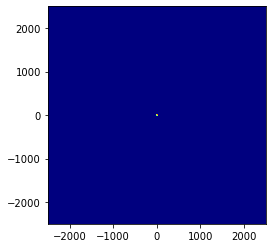

In [10]:
#plot PSF:
plt.imshow(z_psf,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

#### kernel need to be expanded to image (expo) size and padded according to Victor Podlozhnyuk's white paper *FFT-based 2D  convolution*: 

In [11]:
#padded psf prior to fft tansform:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

### 3-3) Build dose distribution:

    dose_dis is the initial dose distribution for this demo pattern. Dose factor = 1 at each dot of the pattern.

In [12]:
NP,WF,final_pattern.shape,final_pattern[:,2].sum()

(2048, 5000, (275781, 3), 275781.0)

In [13]:
from sympy.ntheory import primefactors, factorint
factorint(final_pattern.shape[0]), primefactors(final_pattern.shape[0])

({3: 1, 11: 1, 61: 1, 137: 1}, [3, 11, 61, 137])

In [14]:
#we cut the final_pattern into grid of blocks size:
11*61,3*137

(671, 411)

In [15]:
dose_dis = ker.build_dose_distribution(final_pattern, NP, WF, pixel_size, blockdim=(671,1), griddim=(411,1))

Dose calculated on GPU in 0.175044 s
overlap = -663.0. Negative value = lost dose.
1.0 2.0
  Total Memory: 2048 MiB
  Free Memory: 1615 MiB


In [16]:
# check the beam current and aperture
meb.beam_current, meb.aperture

(28, 7.5)

In [17]:
# Let's exposure at 30 µC/cm²:
dose_dis *= dtfactor(30,ss,meb.beam_current)

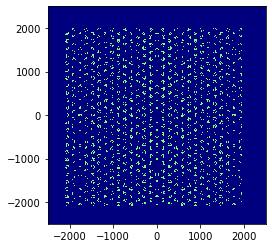

In [18]:
plt.imshow(dose_dis,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

### 3-4) Simulation of ebeam exposure
- This is the exposure simulation for this demo pattern
- you can save the result in a file and reload it later saving simultaion time

#### Expo FFT by convolution
Convolution by FFT principe:
 - apply direct FFT to the convolution kernel (padded)
 - apply direct FFT to the input data array (or image)
 - perform the point-wise multiplication of the two preceding results
 - apply inverse FFT to the result of the multiplication

In [19]:
from pecebl.fft_ops import fft_ops as fft

c:\users\ln\appdata\local\continuum\anaconda3\envs\test2\lib\site-packages\skcuda\cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


**Note:** after these imports numba cuda device allocation won't work anymore unless you restart the python kernel.

We have already got the PSF and dose distribution, so unless you change the beamer parameters or the pattern, you don't need to use numba cuda wrapper anymore.

In [20]:
z = fft.fft_exposure(ppsf, dose_dis)
np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag)

GPU : FFT(psf) = psf in-place fft..
GPU : FFT(dose_pc) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 3.927091 s
64.3 % of device memory is free.
67.4 % of device memory is free.


(0.48392523164921325,
 -6.6062597580571754e-15,
 12.778768601156173,
 5.995890950585919e-15)

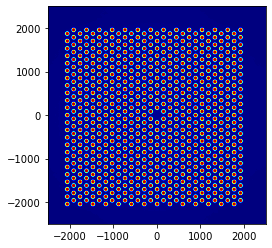

In [21]:
plt.imshow(z.real,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## 4) Develop
- a clearing dose 12 eV/nm with step size 4 nm give resist threshold = 3 eV

In [22]:
filename='R48_D30_30kV_th_3.png'
#z *= 1 #dose increase x times
np.min(z.real),np.mean(z.real), np.max(z.real),np.min(z.imag),np.max(z.imag)

(0.48392523164921325,
 2.7296525167482835,
 12.778768601156173,
 -6.6062597580571754e-15,
 5.995890950585919e-15)

In [23]:
th_resist=3 #clearing dose = 3 eV
z_dev = (z.real> th_resist) * z.real

z_dev[z_dev > 0] = 1

#plt.imshow(z_dev,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

imageio.imwrite(filename, z_dev) #save image to filename

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


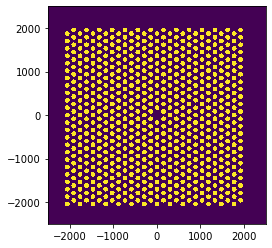

In [24]:
plt.imshow(z_dev,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

## 5) 3D view with pyopengl

may take a while to display

In [25]:
import sys
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg
import pyqtgraph.opengl as gl

In [26]:
app = QtGui.QApplication([])

In [27]:
x=np.linspace(-WF/2,WF/2,NP)
y=np.linspace(-WF/2,WF/2,NP)

#3D GL view:
w = gl.GLViewWidget()
w.show()
w.setWindowTitle('Expo EBL: ')
w.setCameraPosition(distance=50)

## Add a grid to the view
g = gl.GLGridItem()
g.scale(1,1,1)
g.setDepthValue(1)  # draw grid after surfaces since they may be translucent
w.addItem(g)

cmap=plt.get_cmap('jet')
minZ=np.min(z.real);maxZ=np.max(z.real)
rgba_img=cmap((z.real-minZ)/(maxZ-minZ))

## Simple surface plot example
p1 = gl.GLSurfacePlotItem(x,y,z.real, colors=rgba_img)
#p1.translate(0, 0, -np.mean(z))
w.addItem(p1)

if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
    QtGui.QApplication.instance().exec_()